# Short Answer Grading Project

#### Aleksandar Todorov (a.todorov.4@student.rug.nl), Elisa Klunder (e.klunder.1@student.rug.nl), Julia Belloni (j.e.belloni@student.rug.nl)

## Overview
This notebook aims to utilize BERT and different fine-tuning and prompt-engineering techniques for automated short answer grading using the **Hewlett Foundation Short Answer Scoring Dataset**.

## Objectives
- Perform brief exploratory data analysis
- Define experiments, fine-tune and instruction-engineer a BERT classifier to evaluate students' performance
- Evaluate and compare model performance and techniques to determine effectiveness in automated scoring using the Quadratic Weighted Kappa Score

## Dataset
The **Hewlett Foundation Short Answer Scoring Dataset** is used in this project. It contains more than 20,000 short-answer responses on 10 different tasks mainly from Grade 10 students from the United States. Each topic is based on either science, arts, biology, or English. All the answers have been hand-graded on a scale of 0-2 or 0-3 (specified in each task description document) and double-scored for reliability, however, the second score has no effect on the final score received.

---



## Library Installations and System Requirements

The following libraries are essential for the short answer grading pipeline. Please ensure that all dependencies are installed before proceeding.

### System Requirements
To efficiently run the models and achieve optimal performance, it is recommended to use a system with the following specifications:
- **GPU:** NVIDIA V100 (or equivalent) for accelerated model training
- **RAM:** At least 16 GB
- **CPU:** Minimum 8 cores

### Required Libraries
Please uncomment and run the cell below in case the mentioned libraries are not installed.

In [ ]:
# !pip install transformers[torch] transformers torch pandas numpy scikit-learn tqdm peft datasets matplotlib accelerate>=0.26.0

In [1]:
import pandas as pd
import numpy as np

from experiment_runner import (
    CombinedTaskModelStrategy,
    TaskSpecificModelStrategy,
    BaselineBertModelStrategy,
)

import torch
from copy import deepcopy
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

tqdm.pandas()

### Setting Random Seed for Reproducibility

To ensure that our results are reproducible across different runs, we set a fixed random seed. This guarantees that any random operations (e.g., model weight initialization, data shuffling) produce the same results each time the notebook is executed.

In this notebook, we use a **random seed of 4242** for both PyTorch and NumPy libraries to maintain consistency.

Note that since CUDA is non-deterministic, even setting a seed might not achieve complete reproducibility. However, empirically, we achieved the same results by running this notebook several times, so it should not be a problem.


In [2]:
RANDOM_SEED = 4242
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
train_data = pd.read_csv("data/train_rel_2.tsv", sep="\t")
test_data = pd.read_csv("data/public_leaderboard_rel_2.tsv", sep="\t")
test_data_scores = pd.read_csv("data/public_leaderboard_solution.csv")

### Some Data Preprocessing
Since the test set provided by the Hawlett foundation is split into the students' responses and the grades, we need to merge the two.

In [4]:
test_data.head()

,Id,EssaySet,EssayText
0,1673,1,The procedures I think they should have includ...
1,1674,1,"In order to replicate this experiment, you wou..."
2,1675,1,"In order to replicate their experiment, you wo..."
3,1676,1,Pleace a simple of one material into one conta...
4,1677,1,Determin the mass of four different samples ma...


In [5]:
test_data_scores.head()

,Id,EssaySet,EssayWeights,Score1,Usage
0,1673,1,1,1,PublicTest
1,1674,1,1,1,PublicTest
2,1675,1,1,3,PublicTest
3,1676,1,1,0,PublicTest
4,1677,1,1,0,PublicTest


### Merging
Now, the test set contains both the students' responses under ``EssayText`` and the score they received under ``Score1``.

In [6]:
test_data = test_data.merge(test_data_scores, on=["Id", "EssaySet"], how="left")
test_data.drop("Usage", axis=1, inplace=True)
test_data.head()

,Id,EssaySet,EssayText,EssayWeights,Score1
0,1673,1,The procedures I think they should have includ...,1,1
1,1674,1,"In order to replicate this experiment, you wou...",1,1
2,1675,1,"In order to replicate their experiment, you wo...",1,3
3,1676,1,Pleace a simple of one material into one conta...,1,0
4,1677,1,Determin the mass of four different samples ma...,1,0


In [7]:
train_data.drop("Score2", axis=1, inplace=True)
train_data.head()

,Id,EssaySet,Score1,EssayText
0,1,1,1,Some additional information that we would need...
1,2,1,1,"After reading the expirement, I realized that ..."
2,3,1,1,"What you need is more trials, a control set up..."
3,4,1,0,The student should list what rock is better an...
4,5,1,2,For the students to be able to make a replicat...


### Exploratory Data Analysis
Let's perform some EDA to determine the distributions of our data. We only care about ``EssayText`` and ``Score1``.
The scores range from 0 to 3, depending on the essay set. This will be useful later, as we can pass scale to the model directly as an instruction, rather than hardcoding it in the classifier head.

In [8]:
train_data.describe()

,Id,EssaySet,Score1
count,17043.000000,17043.000000,17043.000000
mean,13820.561286,5.609576,0.926245
std,8256.441258,2.822468,0.893137
min,1.000000,1.000000,0.000000
25%,6275.500000,3.000000,0.000000
50%,14270.000000,6.000000,1.000000
75%,20928.500000,8.000000,2.000000
max,27588.000000,10.000000,3.000000


### Unbalanced Scores
The scores have an uneven distribution. This makes sense, as some of the essays are graded on a scale 0-2, and some are graded 0-3. This is discussed in limitations, as several data augmentation techniques could be applied to alleviate this issue.

In [9]:
train_data["Score1"].value_counts()

Score1
0    6731
1    5579
2    3992
3     741
Name: count, dtype: int64

### Response Lengths
We wish to examine some of the structure between the response lengths in words.

Min, Max, and Mean Response length (in words): 1, 325, 42.31


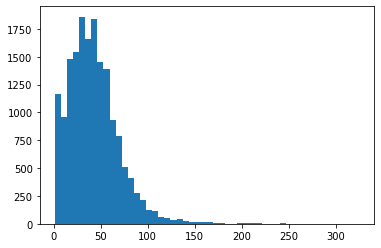

In [17]:
response_lengths = [len(x.split()) for x in train_data["EssayText"]]

plt.hist(response_lengths, bins=50)
min_length = np.min(response_lengths)
max_length = np.max(response_lengths)
mean_length = np.mean(response_lengths)

print(
    f"Min, Max, and Mean Response length (in words): {min_length}, {max_length}, {mean_length:.2f}"
)

### Instruction Fine-tuning
For the instruction finetuning, we explicitly input an instruction prompt into every datapoint that will be given to the model. The instruction is, namely,

*Grade this student's answer on a scale [scale], focusing on grammar, lexical variability, and task relevance.*

In [10]:
augmented_train_data = deepcopy(train_data)
augmented_test_data = deepcopy(test_data)

augmented_train_data["Grading Scale"] = augmented_train_data.groupby("EssaySet")[
    "Score1"
].transform(lambda x: f"{x.min()} to {x.max()}")
augmented_test_data["Grading Scale"] = augmented_test_data.groupby("EssaySet")[
    "Score1"
].transform(lambda x: f"{x.min()} to {x.max()}")

augmented_train_data["EssayText"] = augmented_train_data.apply(
    lambda row: f"Grade this student's answer on a scale {row['Grading Scale']}, focusing on grammar, lexical variability, and task relevance: {row['EssayText']}",
    axis=1,
)
augmented_test_data["EssayText"] = augmented_test_data.apply(
    lambda row: f"Grade this student's answer on a scale {row['Grading Scale']}, focusing on grammar, lexical variability, and task relevance: {row['EssayText']}",
    axis=1,
)

## Experiments
The main goal of this project is to compare fine-tuning (either full or parameter-efficient) strategies, along with instruction-engineering during the fine-tuning. 

Moreover, we wish to examine whether the 100M Uncased BERT is suitable for the short-answer grading task, by fine-tuning it for each specific task, and whether it can generalize enough on all 10 essay tasks at once, achieving a form of multi-task learning. Hence, we define 8 experiments in total:

### Effects of full fine-tuning:
* One BERT for each of the 10 essay tasks, no instruction prompt (raw student answer given), with full fine-tuning
* One BERT for all of the 10 essay tasks at once, no instruction prompt, with full fine-tuning
* One BERT for each of the 10 essay tasks, instruction prompted with the prompt from above, with full fine-tuning
* One BERT for all of the 10 essay tasks at once, instruction prompted, with full fine-tuning

### Effects of LORA fine-tuning:
* One BERT for each of the 10 essay tasks, no instruction prompt (raw student answer given), with LORA fine-tuning
* One BERT for all of the 10 essay tasks at once, no instruction prompt, with LORA fine-tuning
* One BERT for each of the 10 essay tasks, instruction prompted with the prompt from above, with LORA fine-tuning
* One BERT for all of the 10 essay tasks at once, instruction prompted, with LORA fine-tuning

### ExperimentStrategy

**ExperimentStrategy** is an abstract base class designed as a template for defining different strategies to conduct essay scoring experiments. This class provides core attributes and methods, defining the experiment structure while leaving implementation details for specific subclasses.

#### Attributes:
1. **batch_size**: Specifies the number of samples processed per iteration during fine-tuning. Default is 32.
2. **epochs**: Defines the maximum number of times the model will process the entire dataset during training. Default is 10. We do not wish the number of epochs to be reached, rather, we wish the early stopping mechanism to be triggered before that.
3. **patience**: Specifies the maximum allowable number of consecutive epochs without improvement before stopping training early to prevent overfitting. Default is 2.
4. **split_ratio**: Determines the proportion of data used for training versus validation, enabling an optimal division for model training and testing. Default is 0.8.
5. **num_essay_sets**: Represents the number of unique essay sets (tasks), each corresponding to a distinct model training and evaluation. In this project, there are 10 essay sets.

#### Methods:
- **run_experiment(train_data, test_data, instruction=False, retrain=False, evaluate=False, use_lora=False)**:
    - Core method that initiates the tokenization, cross-validation, and training if `retrain=True` and performs predictions and computes QWK (Quadratic Weighted Kappa) for an already existing model if `evaluate=True`.
  
- **_make_predictions(test_data, instruction, use_lora)**:
    - Conducts predictions on the test data for each essay set, evaluates QWK scores for model performance, and computes an average QWK for overall assessment.
  
- **_train_model(train_data, instruction, use_lora)** (abstract):
    - An abstract method for training models, which must be implemented in subclasses.
  
- **_load_model(instruction, essay_set, num_labels, use_lora)** (abstract):
    - An abstract method to load specific models for scoring; subclasses implement specific model loading logic.

---

### TaskSpecificModelStrategy

**TaskSpecificModelStrategy** inherits from `ExperimentStrategy` and implements an experiment where each essay set (task) has a distinct model trained separately. This approach ensures that each model is fine-tuned for a specific essay set.

#### Additional Attributes:
- Inherits all attributes from `ExperimentStrategy`.

#### Methods:
- **_load_model(instruction, essay_set, num_labels, use_lora)**:
    - Loads the trained model for a specific essay set from a pre-defined directory, which includes parameters for LoRA (Low-Rank Adaptation) configuration if enabled.
  
- **_train_model(train_data, instruction, use_lora)**:
    - Trains a distinct model for each essay set by:
        - Splitting the training data into a train and validation set based on `split_ratio`.
        - Tokenizing and creating a dataset for model training and validation.
        - Training the model and saving the best model configuration based on validation loss.

---

### CombinedTaskModelStrategy

**CombinedTaskModelStrategy** is a subclass of `ExperimentStrategy` and trains a single model across all essay sets (tasks), rather than creating a unique model per task. This approach leverages a combined representation for all tasks, enabling a single model to generalize over multiple tasks.

#### Additional Attributes:
- **model**: Stores the single model instance that will be trained and evaluated on all essay sets combined.

#### Methods:
- **_load_model(instruction, essay_set, num_labels, use_lora)**:
    - Loads the combined model from the specified directory path with LoRA if required. Ensures that only one model instance is used across all tasks.

- **_train_model(train_data, instruction, use_lora)**:
    - Trains the single model across all essay sets:
        - Splits the training data into a general training and validation set.
        - Tokenizes the combined dataset and trains the model, storing the best configuration.
        - Evaluates performance using the validation set.

---

### BaselineBertModelStrategy

**BaselineBertModelStrategy** provides a non-training baseline strategy. It loads a pre-trained BERT model without fine-tuning on specific essay sets, serving as a control to compare performance against fine-tuned models.

#### Additional Attributes:
- **model**: A fixed BERT model used to score essays directly without training.

#### Methods:
- **_load_model(instruction, essay_set, num_labels, use_lora=False)**:
    - Returns the non-trained baseline model for scoring.

- **_train_model(train_data, instruction, use_lora=False)**:
    - Contains no implementation for training as this strategy does not involve model fine-tuning or training.


### Task-Specific Model Experiment, Uninstructed, Full Fine-tuning

In this experiment, we instantiate `TaskSpecificModelStrategy` and use the method `run_experiment` to train and evaluate separate models for each essay set (task). This setup is suitable when individual models are desired for each essay set, allowing each model to specialize in scoring responses for that specific task.

#### 1. **Experiment Execution**
   - The experiment is run with the call:
     ```python
     one_model_per_task.run_experiment(train_data, test_data, instruction=False, retrain=True, evaluate=True, lora=False)
     ```
   - Each argument passed to `run_experiment` specifies conditions for this run:
     - `train_data` and `test_data`: Datasets used for training and evaluation. Since this is not an instructed model, we pass the default data, and not the augmented.
     - `instruction=False`: Indicates no special instructions are being used for model training.
     - `retrain=True`: Signals that each model should be re-trained from scratch. Disable this if you do not wish to retrain a model and use an existing one.
     - `evaluate=True`: Specifies that the models should be evaluated post-training. This will load an already existing model for the specified task.
     - `lora=False`: LoRA (Low-Rank Adaptation) is disabled, meaning no parameter-efficient finetuning will be applied, but rather full fine-tuning.

#### 2. **Training Phase**
   - With `retrain=True`, `run_experiment` initiates a distinct model training process for each essay set in the dataset:
     - **Model Initialization**:
       - For each essay set, the `_load_model` method initializes a separate model.
       - Each model is initialized independently, ensuring no shared parameters, which allows each model to focus on the specific language and scoring criteria of its respective task.
     - **Data Splitting**:
       - The provided `train_data` for each essay set is split into a training and validation set based on `split_ratio`.
     - **Tokenization**:
       - The text in `train_data` is tokenized to convert text inputs into the format required by the model.
     - **Model Training**:
       - Each model undergoes training for a maximum of `epochs` epochs.
       - During training, the model monitors the validation loss to ensure it’s not overfitting. If validation loss doesn’t improve for `patience` consecutive epochs, the training process halts early.
     - **Model Saving**:
       - Upon completion of training, the best version of each model (determined by lowest validation loss) is saved, so that the optimal weights are used in evaluation.

#### 3. **Evaluation Phase**
   - With `evaluate=True`, `run_experiment` then proceeds to evaluate each trained model on its respective essay set using the held-out `test_data`.
   - **Prediction Generation**:
     - For each essay set, the `_make_predictions` method uses the trained model to generate predictions on the corresponding test data.
   - **QWK (Quadratic Weighted Kappa) Calculation**:
     - Each model’s predictions are compared to true scores to calculate a QWK score, which measures the agreement between model predictions and actual scores.
     - An average QWK score across all essay sets is also computed, providing an overall metric for the experiment's effectiveness.

#### 4. **Results**
   - After running the experiment, the resulting QWK scores (both per task and averaged) indicate the effectiveness of task-specific training.   
#### Hyperparameters:
`batch_size` = 32, `epochs` = 10, `patience` = 2, `split_ratio` = 0.8

#### Uncomment this cell if you wish to retrain or re-evaluate the model. It is resource-intensive, hence the experiment running cells were commented out to prevent potential missclicks.

In [15]:
# one_model_per_task = TaskSpecificModelStrategy()
# one_model_per_task.run_experiment(train_data, test_data, instruction=False, retrain=True, evaluate=True, use_lora=False)

Tokenizing, cross-validation, and training:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1338 [00:00<?, ? examples/s]

Map:   0%|          | 0/334 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.013100,0.917069
2,0.866500,0.777745
3,0.492900,0.677442
4,0.361700,0.796122
5,0.215800,0.807385


Model saved at directory best_models/bert-base-uncased_set1_instructionFalse/


Final evaluation results: {'eval_loss': 0.6774418354034424, 'eval_runtime': 2.3722, 'eval_samples_per_second': 140.798, 'eval_steps_per_second': 4.637, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1022 [00:00<?, ? examples/s]

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.188000,1.396915
2,1.125300,1.058154
3,0.916200,1.265465
4,0.674600,0.990329
5,0.471900,1.157959
6,0.337400,1.308224


Model saved at directory best_models/bert-base-uncased_set2_instructionFalse/


Final evaluation results: {'eval_loss': 0.9903286695480347, 'eval_runtime': 1.8268, 'eval_samples_per_second': 140.137, 'eval_steps_per_second': 4.379, 'epoch': 6.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1446 [00:00<?, ? examples/s]

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.803200,0.646993
2,0.588700,0.646873
3,0.507300,0.588307
4,0.267100,0.812474
5,0.116400,0.955384


Model saved at directory best_models/bert-base-uncased_set3_instructionFalse/


Final evaluation results: {'eval_loss': 0.5883071422576904, 'eval_runtime': 2.5597, 'eval_samples_per_second': 141.423, 'eval_steps_per_second': 4.688, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1326 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.684300,0.665815
2,0.497800,0.538112
3,0.402700,0.525393
4,0.225700,0.624353
5,0.139700,0.809670


Model saved at directory best_models/bert-base-uncased_set4_instructionFalse/


Final evaluation results: {'eval_loss': 0.5253933668136597, 'eval_runtime': 2.3361, 'eval_samples_per_second': 141.689, 'eval_steps_per_second': 4.709, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1436 [00:00<?, ? examples/s]

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.430200,0.478199
2,0.374500,0.334474
3,0.262500,0.336565
4,0.173600,0.368445


Model saved at directory best_models/bert-base-uncased_set5_instructionFalse/


Final evaluation results: {'eval_loss': 0.3344738185405731, 'eval_runtime': 2.5457, 'eval_samples_per_second': 141.023, 'eval_steps_per_second': 4.714, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1438 [00:00<?, ? examples/s]

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.478300,0.337838
2,0.229000,0.296627
3,0.156300,0.316978
4,0.104100,0.316367


Model saved at directory best_models/bert-base-uncased_set6_instructionFalse/


Final evaluation results: {'eval_loss': 0.2966265380382538, 'eval_runtime': 2.529, 'eval_samples_per_second': 141.954, 'eval_steps_per_second': 4.745, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1439 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.761500,0.699598
2,0.566400,0.752482
3,0.301400,0.629700
4,0.242800,0.823011
5,0.134100,0.860790


Model saved at directory best_models/bert-base-uncased_set7_instructionFalse/


Final evaluation results: {'eval_loss': 0.6296998858451843, 'eval_runtime': 2.5281, 'eval_samples_per_second': 142.398, 'eval_steps_per_second': 4.747, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1439 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.902100,0.828815
2,0.620500,0.708133
3,0.366700,0.738228
4,0.205600,0.842253


Model saved at directory best_models/bert-base-uncased_set8_instructionFalse/


Final evaluation results: {'eval_loss': 0.7081331610679626, 'eval_runtime': 2.5465, 'eval_samples_per_second': 141.369, 'eval_steps_per_second': 4.712, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1438 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.761000,0.708654
2,0.574900,0.648550
3,0.395900,0.650279
4,0.270400,0.743389


Model saved at directory best_models/bert-base-uncased_set9_instructionFalse/


Final evaluation results: {'eval_loss': 0.6485501527786255, 'eval_runtime': 2.5407, 'eval_samples_per_second': 141.696, 'eval_steps_per_second': 4.723, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1312 [00:00<?, ? examples/s]

Map:   0%|          | 0/328 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.645500,0.560466
2,0.420100,0.596392
3,0.342900,0.575854


Model saved at directory best_models/bert-base-uncased_set10_instructionFalse/


Final evaluation results: {'eval_loss': 0.5604664087295532, 'eval_runtime': 2.3401, 'eval_samples_per_second': 140.167, 'eval_steps_per_second': 4.701, 'epoch': 3.0}
Making predictions on test and computing QWK:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/557 [00:00<?, ?it/s]

Essay Set 1: QWK = 0.8227897590123066


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/426 [00:00<?, ?it/s]

Essay Set 2: QWK = 0.7593471345883089


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/406 [00:00<?, ?it/s]

Essay Set 3: QWK = 0.6842261206651771


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/295 [00:00<?, ?it/s]

Essay Set 4: QWK = 0.6865239091933666


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/598 [00:00<?, ?it/s]

Essay Set 5: QWK = 0.6162361623616235


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 6: QWK = 0.7479604478833072


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 7: QWK = 0.6950395914730805


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 8: QWK = 0.6220413980345986


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 9: QWK = 0.8006457963050821


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/546 [00:00<?, ?it/s]

Essay Set 10: QWK = 0.6583960353655927
Average QWK: 0.7093206354882444


### Combined Model Experiment, Uninstructed, Full Fine-tuning

In this experiment, we instantiate `CombinedTaskModelStrategy` and use the method `run_experiment` to train and evaluate a single model for all essay sets (tasks) at once. This allows for more generality and the learning of multiple tasks at once.

#### 1. **Experiment Execution**
   - Equivalent to the Task-Specific Model Experiment, Uninstructed, Full Fine-tuning.

#### 2. **Training Phase**
   - Equivalent to the Task-Specific Model Experiment, Uninstructed, Full Fine-tuning, except that all essay sets are considered at once, and only one model is trained on all of them.

#### 3. **Evaluation Phase**
   - Equivalent to the Task-Specific Model Experiment, Uninstructed, Full Fine-tuning.

#### 4. **Results**
   - Equivalent to the Task-Specific Model Experiment, Uninstructed, Full Fine-tuning.  
   
#### Hyperparameters:
`batch_size` = 32, `epochs` = 10, `patience` = 2, `split_ratio` = 0.8

#### Uncomment this cell if you wish to retrain or re-evaluate the model. It is resource-intensive, hence the experiment running cells were commented out to prevent potential missclicks.

In [16]:
# combined_model = CombinedTaskModelStrategy()
# combined_model.run_experiment(train_data, test_data, instruction=False, retrain=True, evaluate=True, use_lora=False)

Tokenizing, cross-validation, and training:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/13634 [00:00<?, ? examples/s]

Map:   0%|          | 0/3409 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.642700,0.649683
2,0.523600,0.606912
3,0.294000,0.673886
4,0.179200,0.928670
5,0.119200,1.258234


Model saved at directory best_models/bert-base-uncased_all_sets_instructionFalse/


Final evaluation results: {'eval_loss': 0.606911838054657, 'eval_runtime': 23.3607, 'eval_samples_per_second': 145.929, 'eval_steps_per_second': 4.58, 'epoch': 5.0}
Making predictions on test and computing QWK:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/557 [00:00<?, ?it/s]

Essay Set 1: QWK = 0.7849380344295024


  0%|          | 0/426 [00:00<?, ?it/s]

Essay Set 2: QWK = 0.7580709653865545


  0%|          | 0/406 [00:00<?, ?it/s]

Essay Set 3: QWK = 0.6533109583141512


  0%|          | 0/295 [00:00<?, ?it/s]

Essay Set 4: QWK = 0.6863445211457588


  0%|          | 0/598 [00:00<?, ?it/s]

Essay Set 5: QWK = 0.7772098616957306


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 6: QWK = 0.8027594464778958


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 7: QWK = 0.6961498586334636


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 8: QWK = 0.6562620532648472


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 9: QWK = 0.8009908439762745


  0%|          | 0/546 [00:00<?, ?it/s]

Essay Set 10: QWK = 0.7408677546771181
Average QWK: 0.7356904298001296


### Task-Specific Model Experiment, Instructed, Full Fine-tuning

Equivalent to the Task-Specific Model Experiment, Uninstructed, Full Fine-tuning, except that the augmented train and test sets are used for training and evaluation, which contain the instruction prompts.
   
#### Hyperparameters:
`batch_size` = 32, `epochs` = 10, `patience` = 2, `split_ratio` = 0.8

#### Uncomment this cell if you wish to retrain or re-evaluate the model. It is resource-intensive, hence the experiment running cells were commented out to prevent potential missclicks.

In [18]:
# one_model_per_task_instructed = TaskSpecificModelStrategy()
# one_model_per_task_instructed.run_experiment(augmented_train_data, augmented_test_data, instruction=True, retrain=True, evaluate=True, use_lora=False)

Tokenizing, cross-validation, and training:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1338 [00:00<?, ? examples/s]

Map:   0%|          | 0/334 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.032800,0.909605
2,0.825500,0.845307
3,0.602200,0.690195
4,0.451300,0.656934
5,0.347000,0.698679
6,0.256400,0.888361


Model saved at directory best_models/bert-base-uncased_set1_instructionTrue/


Final evaluation results: {'eval_loss': 0.6569340229034424, 'eval_runtime': 2.3479, 'eval_samples_per_second': 142.253, 'eval_steps_per_second': 4.685, 'epoch': 6.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1022 [00:00<?, ? examples/s]

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.357100,1.343936
2,1.231900,1.150132
3,1.025300,1.270954
4,0.849000,1.046668
5,0.660000,1.452588
6,0.455000,1.399208


Model saved at directory best_models/bert-base-uncased_set2_instructionTrue/


Final evaluation results: {'eval_loss': 1.0466675758361816, 'eval_runtime': 1.8446, 'eval_samples_per_second': 138.784, 'eval_steps_per_second': 4.337, 'epoch': 6.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1446 [00:00<?, ? examples/s]

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.843800,0.757823
2,0.609100,0.593204
3,0.590800,0.553322
4,0.447400,0.653415
5,0.235300,0.763320


Model saved at directory best_models/bert-base-uncased_set3_instructionTrue/


Final evaluation results: {'eval_loss': 0.5533217787742615, 'eval_runtime': 2.542, 'eval_samples_per_second': 142.406, 'eval_steps_per_second': 4.721, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1326 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.679500,0.572481
2,0.458400,0.527060
3,0.402600,0.543185
4,0.212000,0.755127


Model saved at directory best_models/bert-base-uncased_set4_instructionTrue/


Final evaluation results: {'eval_loss': 0.5270604491233826, 'eval_runtime': 2.3313, 'eval_samples_per_second': 141.978, 'eval_steps_per_second': 4.718, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1436 [00:00<?, ? examples/s]

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.419300,0.389751
2,0.328000,0.494451
3,0.316800,0.328660
4,0.231200,0.302830
5,0.117100,0.384235
6,0.136300,0.436446


Model saved at directory best_models/bert-base-uncased_set5_instructionTrue/


Final evaluation results: {'eval_loss': 0.3028299808502197, 'eval_runtime': 2.5574, 'eval_samples_per_second': 140.375, 'eval_steps_per_second': 4.692, 'epoch': 6.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1438 [00:00<?, ? examples/s]

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.419900,0.422395
2,0.305500,0.353262
3,0.246000,0.308356
4,0.170400,0.297985
5,0.168500,0.314233
6,0.111200,0.414232


Model saved at directory best_models/bert-base-uncased_set6_instructionTrue/


Final evaluation results: {'eval_loss': 0.2979848384857178, 'eval_runtime': 2.5593, 'eval_samples_per_second': 140.275, 'eval_steps_per_second': 4.689, 'epoch': 6.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1439 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.976900,0.831931
2,0.663300,0.641838
3,0.358900,0.599386
4,0.295700,0.753026
5,0.196400,1.001556


Model saved at directory best_models/bert-base-uncased_set7_instructionTrue/


Final evaluation results: {'eval_loss': 0.5993859171867371, 'eval_runtime': 2.5629, 'eval_samples_per_second': 140.467, 'eval_steps_per_second': 4.682, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1439 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.986800,0.886085
2,0.714000,0.725303
3,0.445400,0.825140
4,0.306100,0.809699


Model saved at directory best_models/bert-base-uncased_set8_instructionTrue/


Final evaluation results: {'eval_loss': 0.7253032922744751, 'eval_runtime': 2.5176, 'eval_samples_per_second': 142.996, 'eval_steps_per_second': 4.767, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1438 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.754100,0.672400
2,0.602900,0.631384
3,0.404000,0.681137
4,0.352700,0.730938


Model saved at directory best_models/bert-base-uncased_set9_instructionTrue/


Final evaluation results: {'eval_loss': 0.6313841938972473, 'eval_runtime': 2.5683, 'eval_samples_per_second': 140.17, 'eval_steps_per_second': 4.672, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1312 [00:00<?, ? examples/s]

Map:   0%|          | 0/328 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.663300,0.559820
2,0.453600,0.686501
3,0.418400,0.543796
4,0.281900,0.580738
5,0.150700,0.774494


Model saved at directory best_models/bert-base-uncased_set10_instructionTrue/


Final evaluation results: {'eval_loss': 0.5437957644462585, 'eval_runtime': 2.3527, 'eval_samples_per_second': 139.413, 'eval_steps_per_second': 4.675, 'epoch': 5.0}
Making predictions on test and computing QWK:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/557 [00:00<?, ?it/s]

Essay Set 1: QWK = 0.8391086376250501


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/426 [00:00<?, ?it/s]

Essay Set 2: QWK = 0.7378468583221812


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/406 [00:00<?, ?it/s]

Essay Set 3: QWK = 0.6880684413804561


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/295 [00:00<?, ?it/s]

Essay Set 4: QWK = 0.6723541247484909


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/598 [00:00<?, ?it/s]

Essay Set 5: QWK = 0.8108277264903772


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 6: QWK = 0.8509945171216422


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 7: QWK = 0.6639380102504306


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 8: QWK = 0.5873180207890191


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 9: QWK = 0.8038286204679159


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/546 [00:00<?, ?it/s]

Essay Set 10: QWK = 0.7250459371564324
Average QWK: 0.7379330894351996


### Combined Model Experiment, Instructed, Full Fine-tuning

Equivalent to the Combined Model Experiment, Uninstructed, Full Fine-tuning, except that the augmented train and test sets are used for training and evaluation, which contain the instruction prompts.
   
#### Hyperparameters:
`batch_size` = 32, `epochs` = 10, `patience` = 2, `split_ratio` = 0.8

#### Uncomment this cell if you wish to retrain or re-evaluate the model. It is resource-intensive, hence the experiment running cells were commented out to prevent potential missclicks.

In [19]:
# combined_model = CombinedTaskModelStrategy()
# combined_model.run_experiment(augmented_train_data, augmented_test_data, instruction=True, retrain=True, evaluate=True, use_lora=False)

Tokenizing, cross-validation, and training:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/13634 [00:00<?, ? examples/s]

Map:   0%|          | 0/3409 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.664000,0.679146
2,0.594100,0.586748
3,0.331700,0.680708
4,0.221400,0.816210
5,0.140200,1.005692


Model saved at directory best_models/bert-base-uncased_all_sets_instructionTrue/


Final evaluation results: {'eval_loss': 0.5867482423782349, 'eval_runtime': 23.3454, 'eval_samples_per_second': 146.024, 'eval_steps_per_second': 4.583, 'epoch': 5.0}
Making predictions on test and computing QWK:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/557 [00:00<?, ?it/s]

Essay Set 1: QWK = 0.7654766318726552


  0%|          | 0/426 [00:00<?, ?it/s]

Essay Set 2: QWK = 0.743740130836905


  0%|          | 0/406 [00:00<?, ?it/s]

Essay Set 3: QWK = 0.6972338822516413


  0%|          | 0/295 [00:00<?, ?it/s]

Essay Set 4: QWK = 0.6809811143327325


  0%|          | 0/598 [00:00<?, ?it/s]

Essay Set 5: QWK = 0.7676975945017183


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 6: QWK = 0.8062813221122866


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 7: QWK = 0.6471931252224334


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 8: QWK = 0.6727335941854626


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 9: QWK = 0.8145690774426954


  0%|          | 0/546 [00:00<?, ?it/s]

Essay Set 10: QWK = 0.7722458100558659
Average QWK: 0.7368152282814396


### LoRA Experiments

The equivalent 4 experiments as above were executed, with `use_lora=True`, annotating that parameter-efficient fine-tuning with LoRA was used.

### Default Hyperparameters

The same hyperparameters as the previous 4 experiments were used, except epochs. We found that LoRA has a smoother and slower training process, hence we want to allow the early stopping mechanism to trigger before the final epoch.

`batch_size` = 32, `epochs` = 50, `patience` = 2, `split_ratio` = 0.8

### LoRA Hyperparameters

The specific hyperparameters for the LoRA configuration in this context are:

- **Task Type**: `SEQ_CLS` (indicating the model is tailored for sequence classification tasks).
  
- **Rank (`r`)**: `16` (defining the dimensionality of the low-rank matrices).
  
- **LoRA Alpha**: `16` (scaling factor for the output of the low-rank matrices).
  
- **Target Modules**: `["query", "value"]` (specifying which model components are adapted). Those are the components that need to be specified for BERT.
  
- **LoRA Dropout**: `0.1` (introducing regularization to prevent overfitting).


### Task-Specific Model Experiment, Uninstructed, LoRA Fine-tuning

Equivalent to the Task-Specific Model Experiment, Uninstructed, Full Fine-tuning, except that LoRA fine-tuning is applied instead.
   
#### Hyperparameters:
`batch_size` = 32, `epochs` = 50, `patience` = 2, `split_ratio` = 0.8

#### Uncomment this cell if you wish to retrain or re-evaluate the model. It is resource-intensive, hence the experiment running cells were commented out to prevent potential missclicks.

In [12]:
lora_one_model_per_task = TaskSpecificModelStrategy(epochs=50, patience=2)
lora_one_model_per_task.run_experiment(
    train_data, test_data, instruction=False, retrain=True, evaluate=True, use_lora=True
)

Tokenizing, cross-validation, and training:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1338 [00:00<?, ? examples/s]

Map:   0%|          | 0/334 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.369700,1.362379
2,1.366000,1.340228
3,1.323400,1.295718
4,1.261000,1.161445
5,1.105600,1.041589
6,1.072900,0.999385
7,1.007700,0.978006
8,0.979800,0.942574
9,0.923800,0.924252
10,0.959900,0.900446


Model saved at directory best_models/bert-base-uncased_set1_instructionFalse_loraTrue/


Final evaluation results: {'eval_loss': 0.794653594493866, 'eval_runtime': 2.406, 'eval_samples_per_second': 138.822, 'eval_steps_per_second': 4.572, 'epoch': 22.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1022 [00:00<?, ? examples/s]

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.337100,1.338141
2,1.326600,1.335527
3,1.340000,1.335434
4,1.332800,1.329868
5,1.292800,1.325641
6,1.313000,1.317576
7,1.290800,1.295700
8,1.275000,1.288677
9,1.230000,1.256488
10,1.192200,1.272390


Model saved at directory best_models/bert-base-uncased_set2_instructionFalse_loraTrue/


Final evaluation results: {'eval_loss': 1.2564880847930908, 'eval_runtime': 1.8646, 'eval_samples_per_second': 137.295, 'eval_steps_per_second': 4.29, 'epoch': 11.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1446 [00:00<?, ? examples/s]

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.026300,0.960679
2,0.956000,0.926313
3,0.954100,0.864478
4,0.819300,0.783452
5,0.773700,0.707795
6,0.748200,0.655347
7,0.663800,0.616577
8,0.718900,0.593780
9,0.620600,0.571807
10,0.597600,0.566354


Model saved at directory best_models/bert-base-uncased_set3_instructionFalse_loraTrue/


Final evaluation results: {'eval_loss': 0.5481148958206177, 'eval_runtime': 2.6231, 'eval_samples_per_second': 138.007, 'eval_steps_per_second': 4.575, 'epoch': 16.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1326 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.935300,0.899292
2,0.855300,0.875839
3,0.858900,0.839305
4,0.802400,0.772162
5,0.714200,0.700205
6,0.664400,0.657496
7,0.631600,0.603675
8,0.608600,0.576714
9,0.555600,0.574854
10,0.523000,0.558625


Model saved at directory best_models/bert-base-uncased_set4_instructionFalse_loraTrue/


Final evaluation results: {'eval_loss': 0.5277724862098694, 'eval_runtime': 2.4268, 'eval_samples_per_second': 136.393, 'eval_steps_per_second': 4.533, 'epoch': 14.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1436 [00:00<?, ? examples/s]

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.792300,0.654522
2,0.627500,0.566943
3,0.543600,0.507260
4,0.506600,0.462972
5,0.413700,0.431684
6,0.451700,0.409842
7,0.458400,0.398597
8,0.345400,0.384282
9,0.377000,0.370755
10,0.352200,0.366418


Model saved at directory best_models/bert-base-uncased_set5_instructionFalse_loraTrue/


Final evaluation results: {'eval_loss': 0.345051109790802, 'eval_runtime': 2.6033, 'eval_samples_per_second': 137.9, 'eval_steps_per_second': 4.609, 'epoch': 18.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1438 [00:00<?, ? examples/s]

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.140700,0.952349
2,0.521400,0.589787
3,0.405400,0.457234
4,0.340400,0.406509
5,0.369800,0.380839
6,0.413600,0.375538
7,0.280100,0.345541
8,0.301500,0.326039
9,0.277000,0.322385
10,0.307800,0.311266


Model saved at directory best_models/bert-base-uncased_set6_instructionFalse_loraTrue/


Final evaluation results: {'eval_loss': 0.27866995334625244, 'eval_runtime': 2.5889, 'eval_samples_per_second': 138.668, 'eval_steps_per_second': 4.635, 'epoch': 22.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1439 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.048700,1.034840
2,1.031600,1.022403
3,0.989300,0.999570
4,0.966200,0.977776
5,0.894500,0.950051
6,0.895200,0.930074
7,0.832100,0.880782
8,0.792300,0.853589
9,0.764100,0.824907
10,0.693600,0.806971


Model saved at directory best_models/bert-base-uncased_set7_instructionFalse_loraTrue/


Final evaluation results: {'eval_loss': 0.7462363243103027, 'eval_runtime': 2.616, 'eval_samples_per_second': 137.616, 'eval_steps_per_second': 4.587, 'epoch': 17.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1439 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.083600,1.042180
2,1.009200,0.993073
3,0.938800,0.935215
4,0.941500,0.922010
5,0.945600,0.919272
6,0.936400,0.916951
7,0.896100,0.896566
8,0.906300,0.889541
9,0.881000,0.880246
10,0.833500,0.865242


Model saved at directory best_models/bert-base-uncased_set8_instructionFalse_loraTrue/


Final evaluation results: {'eval_loss': 0.7537193894386292, 'eval_runtime': 2.5898, 'eval_samples_per_second': 139.005, 'eval_steps_per_second': 4.633, 'epoch': 24.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1438 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.066700,1.026995
2,1.005000,0.928872
3,0.863500,0.838726
4,0.802000,0.795813
5,0.773100,0.784548
6,0.711600,0.752958
7,0.648000,0.741647
8,0.703900,0.727196
9,0.605500,0.714874
10,0.637900,0.702975


Model saved at directory best_models/bert-base-uncased_set9_instructionFalse_loraTrue/


Final evaluation results: {'eval_loss': 0.6463626623153687, 'eval_runtime': 2.6085, 'eval_samples_per_second': 138.011, 'eval_steps_per_second': 4.6, 'epoch': 19.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1312 [00:00<?, ? examples/s]

Map:   0%|          | 0/328 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.049800,0.990637
2,0.932000,0.866466
3,0.823700,0.761026
4,0.724300,0.717785
5,0.777200,0.700777
6,0.707900,0.677631
7,0.702800,0.669477
8,0.689500,0.681353
9,0.691800,0.653610
10,0.667900,0.644680


Model saved at directory best_models/bert-base-uncased_set10_instructionFalse_loraTrue/


Final evaluation results: {'eval_loss': 0.6209270358085632, 'eval_runtime': 2.3812, 'eval_samples_per_second': 137.745, 'eval_steps_per_second': 4.62, 'epoch': 19.0}
Making predictions on test and computing QWK:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/557 [00:00<?, ?it/s]

Essay Set 1: QWK = 0.02360640411359105


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/426 [00:00<?, ?it/s]

Essay Set 2: QWK = 0.05964635081441516


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/406 [00:00<?, ?it/s]

Essay Set 3: QWK = 0.0690616319035734


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/295 [00:00<?, ?it/s]

Essay Set 4: QWK = -0.00382484832498009


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/598 [00:00<?, ?it/s]

Essay Set 5: QWK = 0.18229290291953482


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 6: QWK = 0.019847883397472676


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 7: QWK = -0.0021758729498249085


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 8: QWK = 0.028899128855403577


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 9: QWK = 0.4136620225798703


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/546 [00:00<?, ?it/s]

Essay Set 10: QWK = 0.05705136661829446
Average QWK: 0.08480669699273505


### Combined Model Experiment, Uninstructed, LoRA Fine-tuning

Equivalent to the Combined Model Experiment, Uninstructed, Full Fine-tuning, except that LoRA fine-tuning is applied instead.
   
#### Hyperparameters:
`batch_size` = 32, `epochs` = 50, `patience` = 2, `split_ratio` = 0.8

#### Uncomment this cell if you wish to retrain or re-evaluate the model. It is resource-intensive, hence the experiment running cells were commented out to prevent potential missclicks.

In [13]:
lora_combined_model = CombinedTaskModelStrategy(epochs=50, patience=2)
lora_combined_model.run_experiment(
    train_data, test_data, instruction=False, retrain=True, evaluate=True, use_lora=True
)

Tokenizing, cross-validation, and training:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/13634 [00:00<?, ? examples/s]

Map:   0%|          | 0/3409 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.890400,0.910516
2,0.845600,0.845603
3,0.814600,0.818484
4,0.770300,0.783386
5,0.694600,0.756242
6,0.711700,0.735905
7,0.706400,0.717000
8,0.772600,0.708481
9,0.731500,0.702140
10,0.696200,0.692515


Model saved at directory best_models/bert-base-uncased_all_sets_instructionFalse_loraTrue/


Final evaluation results: {'eval_loss': 0.656749963760376, 'eval_runtime': 23.9572, 'eval_samples_per_second': 142.295, 'eval_steps_per_second': 4.466, 'epoch': 19.0}
Making predictions on test and computing QWK:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/557 [00:00<?, ?it/s]

Essay Set 1: QWK = 0.11341414353430945


  0%|          | 0/426 [00:00<?, ?it/s]

Essay Set 2: QWK = 0.09815051762242633


  0%|          | 0/406 [00:00<?, ?it/s]

Essay Set 3: QWK = 0.3096165033337809


  0%|          | 0/295 [00:00<?, ?it/s]

Essay Set 4: QWK = 0.1218227616212505


  0%|          | 0/598 [00:00<?, ?it/s]

Essay Set 5: QWK = 0.12825971261309166


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 6: QWK = 0.16418132481682446


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 7: QWK = 0.053094818002876076


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 8: QWK = 0.1749331059214133


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 9: QWK = 0.376580189876631


  0%|          | 0/546 [00:00<?, ?it/s]

Essay Set 10: QWK = 0.27448555873396685
Average QWK: 0.18145386360765708


### Task-Specific Model Experiment, Instructed, LoRA Fine-tuning

Equivalent to the Task-Specific Model Experiment, Instructed, Full Fine-tuning, except that LoRA fine-tuning is applied instead.
   
#### Hyperparameters:
`batch_size` = 32, `epochs` = 50, `patience` = 2, `split_ratio` = 0.8

#### Uncomment this cell if you wish to retrain or re-evaluate the model. It is resource-intensive, hence the experiment running cells were commented out to prevent potential missclicks.

In [18]:
lora_one_model_per_task = TaskSpecificModelStrategy(epochs=50, patience=2)
lora_one_model_per_task.run_experiment(
    augmented_train_data,
    augmented_test_data,
    instruction=True,
    retrain=True,
    evaluate=True,
    use_lora=True,
)

Tokenizing, cross-validation, and training:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1338 [00:00<?, ? examples/s]

Map:   0%|          | 0/334 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.373200,1.367736
2,1.372200,1.354227
3,1.340700,1.336388
4,1.313000,1.256868
5,1.188200,1.108004
6,1.095000,1.027110
7,1.045000,0.990231
8,0.989200,0.961560
9,0.919200,0.950513
10,0.936700,0.914022


Model saved at directory best_models/bert-base-uncased_set1_instructionTrue_loraTrue/


Final evaluation results: {'eval_loss': 0.7382587790489197, 'eval_runtime': 2.3665, 'eval_samples_per_second': 141.14, 'eval_steps_per_second': 4.648, 'epoch': 31.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1022 [00:00<?, ? examples/s]

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.339600,1.334260
2,1.334300,1.331538
3,1.340800,1.332178
4,1.332900,1.330071
5,1.303000,1.328063
6,1.333600,1.326987
7,1.346700,1.322451
8,1.303600,1.315817
9,1.296100,1.306689
10,1.259800,1.292701


Model saved at directory best_models/bert-base-uncased_set2_instructionTrue_loraTrue/


Final evaluation results: {'eval_loss': 1.1242625713348389, 'eval_runtime': 1.9166, 'eval_samples_per_second': 133.568, 'eval_steps_per_second': 4.174, 'epoch': 24.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1446 [00:00<?, ? examples/s]

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.003200,0.970974
2,0.977000,0.960788
3,0.999600,0.945732
4,0.922500,0.903063
5,0.912400,0.853851
6,0.840300,0.807870
7,0.750800,0.739750
8,0.782700,0.703778
9,0.686000,0.664701
10,0.679000,0.636844


Model saved at directory best_models/bert-base-uncased_set3_instructionTrue_loraTrue/


Final evaluation results: {'eval_loss': 0.5570264458656311, 'eval_runtime': 2.6127, 'eval_samples_per_second': 138.556, 'eval_steps_per_second': 4.593, 'epoch': 19.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1326 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.986300,0.930888
2,0.863600,0.863918
3,0.847500,0.807650
4,0.801000,0.747740
5,0.728500,0.683529
6,0.685000,0.645374
7,0.629200,0.599221
8,0.633300,0.578777
9,0.626800,0.566571
10,0.568500,0.551256


Model saved at directory best_models/bert-base-uncased_set4_instructionTrue_loraTrue/


Final evaluation results: {'eval_loss': 0.5365453362464905, 'eval_runtime': 2.4253, 'eval_samples_per_second': 136.478, 'eval_steps_per_second': 4.536, 'epoch': 14.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1436 [00:00<?, ? examples/s]

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.753000,0.638215
2,0.628000,0.555031
3,0.520000,0.493493
4,0.517800,0.450729
5,0.384100,0.424976
6,0.439600,0.400711
7,0.481600,0.383989
8,0.373300,0.375988
9,0.363700,0.366621
10,0.356500,0.364631


Model saved at directory best_models/bert-base-uncased_set5_instructionTrue_loraTrue/


Final evaluation results: {'eval_loss': 0.35258668661117554, 'eval_runtime': 2.6488, 'eval_samples_per_second': 135.532, 'eval_steps_per_second': 4.53, 'epoch': 14.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1438 [00:00<?, ? examples/s]

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.697800,0.629236
2,0.466300,0.541886
3,0.412600,0.497385
4,0.368500,0.445538
5,0.381000,0.444752
6,0.475800,0.383348
7,0.319900,0.395778
8,0.369800,0.357494
9,0.325900,0.344628
10,0.346700,0.342661


Model saved at directory best_models/bert-base-uncased_set6_instructionTrue_loraTrue/


Final evaluation results: {'eval_loss': 0.30272263288497925, 'eval_runtime': 2.6152, 'eval_samples_per_second': 137.276, 'eval_steps_per_second': 4.589, 'epoch': 23.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1439 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.051200,1.031335
2,1.023000,1.026095
3,0.992500,1.011471
4,0.983200,0.994434
5,0.924900,0.975223
6,0.919500,0.963456
7,0.883600,0.926247
8,0.812300,0.901143
9,0.821400,0.861953
10,0.746200,0.837415


Model saved at directory best_models/bert-base-uncased_set7_instructionTrue_loraTrue/


Final evaluation results: {'eval_loss': 0.8130593299865723, 'eval_runtime': 2.6338, 'eval_samples_per_second': 136.687, 'eval_steps_per_second': 4.556, 'epoch': 13.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1439 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.077600,1.027037
2,1.019000,0.995030
3,0.980700,0.952936
4,0.958500,0.917968
5,0.935200,0.915544
6,0.941200,0.907742
7,0.888900,0.898237
8,0.946800,0.898864
9,0.931100,0.890979
10,0.847100,0.888410


Model saved at directory best_models/bert-base-uncased_set8_instructionTrue_loraTrue/


Final evaluation results: {'eval_loss': 0.8555623292922974, 'eval_runtime': 2.6011, 'eval_samples_per_second': 138.401, 'eval_steps_per_second': 4.613, 'epoch': 17.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1438 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.081100,1.037145
2,0.987800,0.920840
3,0.844000,0.830823
4,0.778400,0.812118
5,0.759500,0.803270
6,0.720900,0.783263
7,0.678800,0.772949
8,0.723800,0.752999
9,0.622700,0.750851
10,0.664500,0.738513


Model saved at directory best_models/bert-base-uncased_set9_instructionTrue_loraTrue/


Final evaluation results: {'eval_loss': 0.6508246660232544, 'eval_runtime': 2.5977, 'eval_samples_per_second': 138.586, 'eval_steps_per_second': 4.62, 'epoch': 22.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1312 [00:00<?, ? examples/s]

Map:   0%|          | 0/328 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.019100,0.988181
2,0.942600,0.922494
3,0.881500,0.794028
4,0.731100,0.714568
5,0.773700,0.717691
6,0.721300,0.701551
7,0.691800,0.688449
8,0.718300,0.689557
9,0.696800,0.666944
10,0.679500,0.653494


Model saved at directory best_models/bert-base-uncased_set10_instructionTrue_loraTrue/


Final evaluation results: {'eval_loss': 0.5677561163902283, 'eval_runtime': 2.4051, 'eval_samples_per_second': 136.379, 'eval_steps_per_second': 4.574, 'epoch': 24.0}
Making predictions on test and computing QWK:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/557 [00:00<?, ?it/s]

Essay Set 1: QWK = -0.004066461855843917


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/426 [00:00<?, ?it/s]

Essay Set 2: QWK = 0.031222409503170234


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/406 [00:00<?, ?it/s]

Essay Set 3: QWK = 0.023026403254540306


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/295 [00:00<?, ?it/s]

Essay Set 4: QWK = -0.013988808952837717


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/598 [00:00<?, ?it/s]

Essay Set 5: QWK = 0.23000432338953736


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 6: QWK = 0.07802510063935597


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 7: QWK = 0.07074978281297095


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 8: QWK = 0.1529353535770155


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 9: QWK = -0.07226717784378844


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/546 [00:00<?, ?it/s]

Essay Set 10: QWK = -0.003074918566775331
Average QWK: 0.04925660059573449


### Combined Model Experiment, Instructed, LoRA Fine-tuning

Equivalent to the Combined Model Experiment, Instructed, Full Fine-tuning, except that LoRA fine-tuning is applied instead.
   
#### Hyperparameters:
`batch_size` = 32, `epochs` = 50, `patience` = 2, `split_ratio` = 0.8

#### Uncomment this cell if you wish to retrain or re-evaluate the model. It is resource-intensive, hence the experiment running cells were commented out to prevent potential missclicks.

In [19]:
lora_combined_model = CombinedTaskModelStrategy(epochs=50, patience=2)
lora_combined_model.run_experiment(
    augmented_train_data,
    augmented_test_data,
    instruction=True,
    retrain=True,
    evaluate=True,
    use_lora=True,
)

Tokenizing, cross-validation, and training:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/13634 [00:00<?, ? examples/s]

Map:   0%|          | 0/3409 [00:00<?, ? examples/s]

/home3/s5100534/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.923100,0.920144
2,0.853000,0.855799
3,0.820000,0.825078
4,0.780400,0.802300
5,0.731100,0.771789
6,0.696600,0.745547
7,0.764200,0.719672
8,0.801500,0.710148
9,0.779900,0.702669
10,0.712400,0.702639


Model saved at directory best_models/bert-base-uncased_all_sets_instructionTrue_loraTrue/


Final evaluation results: {'eval_loss': 0.678668737411499, 'eval_runtime': 24.0959, 'eval_samples_per_second': 141.477, 'eval_steps_per_second': 4.441, 'epoch': 16.0}
Making predictions on test and computing QWK:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/557 [00:00<?, ?it/s]

Essay Set 1: QWK = 0.04831254865620527


  0%|          | 0/426 [00:00<?, ?it/s]

Essay Set 2: QWK = 0.025052337060591845


  0%|          | 0/406 [00:00<?, ?it/s]

Essay Set 3: QWK = 0.21856398098224405


  0%|          | 0/295 [00:00<?, ?it/s]

Essay Set 4: QWK = 0.0883381924198251


  0%|          | 0/598 [00:00<?, ?it/s]

Essay Set 5: QWK = 0.2797365362262688


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 6: QWK = 0.2630518871943427


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 7: QWK = 0.16179385589903517


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 8: QWK = 0.08211158048508693


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 9: QWK = 0.141327873883478


  0%|          | 0/546 [00:00<?, ?it/s]

Essay Set 10: QWK = 0.040560743274446365
Average QWK: 0.13488495360815242


### Baselines
The pre-trained BERT model was used as a baseline. We consider two baselines, one without the instruction prompt, and one with.

In [20]:
baseline_model = BaselineBertModelStrategy()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Uninstructed Baseline BERT

Similar to the manner in which the previous experiments were executed, the baseline pre-trained BERT was used to generate predictions and they were evaluated across all 10 datasets using the QWK score.

In [21]:
baseline_model.run_experiment(
    train_data, test_data, instruction=False, retrain=False, evaluate=True
)

Making predictions on test and computing QWK:


  0%|          | 0/557 [00:00<?, ?it/s]

Essay Set 1: QWK = 0.0031610527462127003


  0%|          | 0/426 [00:00<?, ?it/s]

Essay Set 2: QWK = -0.0016813297487161538


  0%|          | 0/406 [00:00<?, ?it/s]

Essay Set 3: QWK = 0.0


  0%|          | 0/295 [00:00<?, ?it/s]

Essay Set 4: QWK = -0.015470895378070004


  0%|          | 0/598 [00:00<?, ?it/s]

Essay Set 5: QWK = 0.0


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 6: QWK = -0.0009548818333733333


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 7: QWK = 0.003566533143473105


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 8: QWK = 0.000557519442480614


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 9: QWK = 0.0


  0%|          | 0/546 [00:00<?, ?it/s]

Essay Set 10: QWK = 0.0
Average QWK: -0.0010822001627993072


### Instructed Baseline BERT

Similar to the manner in which the previous experiments were executed, the baseline pre-trained BERT was used to generate predictions on the augmented instructed test set and they were evaluated across all 10 datasets using the QWK score.

In [22]:
baseline_model.run_experiment(
    augmented_train_data,
    augmented_test_data,
    instruction=True,
    retrain=False,
    evaluate=True,
)

Making predictions on test and computing QWK:


  0%|          | 0/557 [00:00<?, ?it/s]

Essay Set 1: QWK = 0.0015787842206292924


  0%|          | 0/426 [00:00<?, ?it/s]

Essay Set 2: QWK = -0.0020196982919837847


  0%|          | 0/406 [00:00<?, ?it/s]

Essay Set 3: QWK = 0.0


  0%|          | 0/295 [00:00<?, ?it/s]

Essay Set 4: QWK = -0.0030429317986373494


  0%|          | 0/598 [00:00<?, ?it/s]

Essay Set 5: QWK = -0.009992505620784353


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 6: QWK = 0.012455359680812128


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 7: QWK = 0.00047805826391988937


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 8: QWK = -0.001853578135343703


  0%|          | 0/599 [00:00<?, ?it/s]

Essay Set 9: QWK = 0.0010223123484652819


  0%|          | 0/546 [00:00<?, ?it/s]

Essay Set 10: QWK = -0.0008162023075009017
Average QWK: -0.00021904016404235006
